## Note
this Jupyter notebook should be ran with a kernel from a virtualenvironment where the requirements in `task_2/requirements.txt` have been installed.

In [1]:
#import required libaries
import pandas as pd
from plotnine import (
    ggtitle,
    ggplot,
    aes,
    after_stat,
    theme,
    geom_bar,
    geom_text,
    element_text,
    geom_density,
    geom_boxplot,
)
from scipy import stats
import numpy as np

In [18]:
#define functions to be used:
##Plots
#bar plot
def create_bar_plot(df: pd.DataFrame, column_name: str, title: str):
    """Creates a bar plot from a categorical variable with a title from a pandas dataframe and column name.

     Args:
         df (pd.DataFrame): the pandas dataframe to be used.
         column_name (str): the name of the column to plot
         title (str): the title wanted for the plot

     Returns:
         plotnine bar plot with percentages for each category.

     """
    plot = (ggplot(df, aes(column_name, fill=column_name))
+ ggtitle(title)
+ geom_bar()
+ geom_text(
    aes(label=after_stat("prop*100"), group=1),
    stat="count",
    nudge_x=0.10,
    nudge_y=0.125,
    va="bottom",
    format_string=" ({:.1f}%)",
)
+theme(axis_text_x=element_text(rotation=45, hjust=1, size=7))
)
    return plot


#Density plot
def create_distribution_plot(df:pd.DataFrame, column_name:str, title:str ):
    """Creates a density plot from a continuous variable with a title from a pandas dataframe and column name.

     Args:
         df (pd.DataFrame): the pandas dataframe to be used.
         column_name (str): the name of the column to plot
         title (str): the title wanted for the plot

     Returns:
         plotnine density plot.
    """
    plot = (
    ggplot(df, aes(x=column_name))
    +geom_density()
    +ggtitle(title)
)
    return plot


#Boxplot
def create_boxplot(df:pd.DataFrame, x_column_title:str, y_column_title:str):
    """Creates a box plot from a continuous variable.

     Args:
         df (pd.DataFrame): the pandas dataframe to be used.
         x_column_title (str): the name of the x column to plot.
         y_column_title (str): the name of the y column to plot.

     Returns:
         plotnine box plot.
    """
    plot = (
        ggplot(df)
        +geom_boxplot(aes(x=x_column_title, y=y_column_title))
    )
    return plot


## Explore data

In [3]:
pos_compounds = pd.read_csv("spike_positive_compounds.csv")
pos_compounds.head()

,drug_name,feature_1,feature_2,feature_3
0,screen_0,"C,N,S,O",15.389781,0.746519
1,screen_1,"S,O",16.470980,0.256326
2,screen_2,"N,S",12.156914,0.050299
3,screen_3,"C,S",18.668487,0.439532
4,screen_4,"S,O",28.694484,0.423299


In [6]:
pos_compounds.shape

(50, 4)

We can see that feature 1 is categorical while features 2 and 3 are continuous.

In [5]:
approved_compounds = pd.read_csv("approved_drugs.csv")
approved_compounds.head()

,drug_name,feature_1,feature_2,feature_3
0,PRAZOSIN,"C,N,O",-0.911904,0.116277
1,NICOTINE,"C,N",-1.344568,0.941203
2,OFLOXACIN,"C,N,O",-12.845686,0.072455
3,NALIDIXIC ACID,"C,N,O",18.445127,0.754685
4,ELLAGIC ACID,"C,O",3.265101,0.851752


In [7]:
approved_compounds.shape

(4913, 4)

In [8]:
#We could try to merge on the three columns to see if the positive compounds are in the approved compounds:

merged = pos_compounds.merge(approved_compounds, on=["feature_1", "feature_2", "feature_3"], how="left")
merged.shape

(50, 5)

In [9]:
merged.drug_name_y.value_counts()

Series([], Name: count, dtype: int64)

We can see that the active compounds against the Covid-19 spike protein are not in the approved compounds.

## Feature 1 exploration

### Summary statistics

In [10]:
#we first look at the category counts in both datasets:
pos_compounds.feature_1.value_counts()

feature_1
N,S,O      10
C,S         8
C,N,S,O     7
N,S         7
S           5
C,S,O       5
S,O         4
C,N,S       4
Name: count, dtype: int64

In [80]:
approved_compounds.feature_1.value_counts()

feature_1
C,N,O      2811
C,N,S,O     864
C,O         671
C,N         284
C,S,O        75
C            55
C,N,S        51
S,O          23
O            22
N            16
N,O          16
N,S,O        13
C,S           6
S             5
N,S           1
Name: count, dtype: int64

We can see that potentially feature 1 is important for activity against the covid spike protein as there are only 8 values in the positive compound dataset which seem quite rare in the approved compound dataset.

### Distribution of feature 1

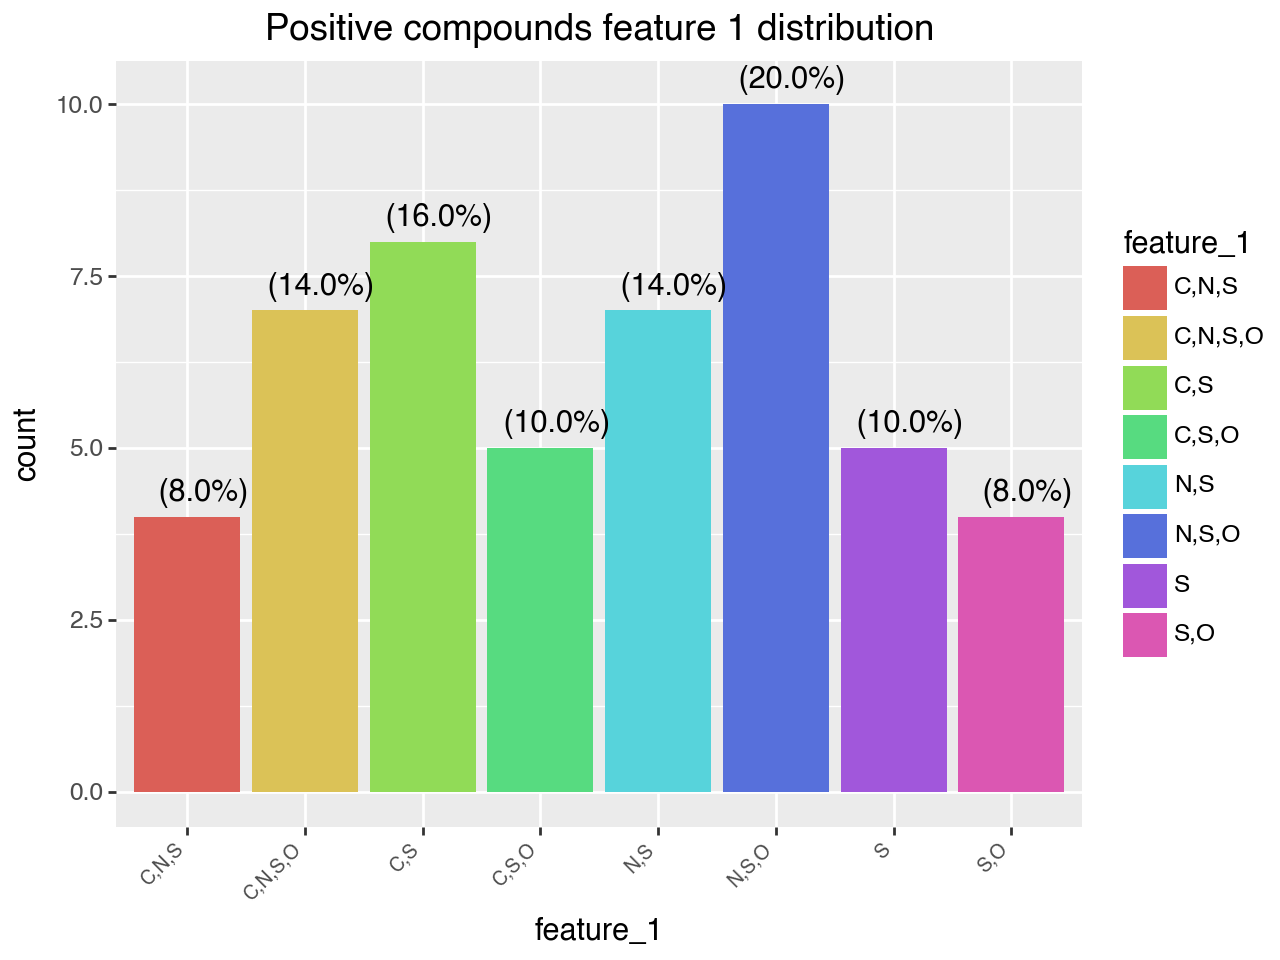

In [12]:
#we look at the distribution of the different categories in feature with a plot for both datasets:
create_bar_plot(pos_compounds, "feature_1", "Positive compounds feature 1 distribution")

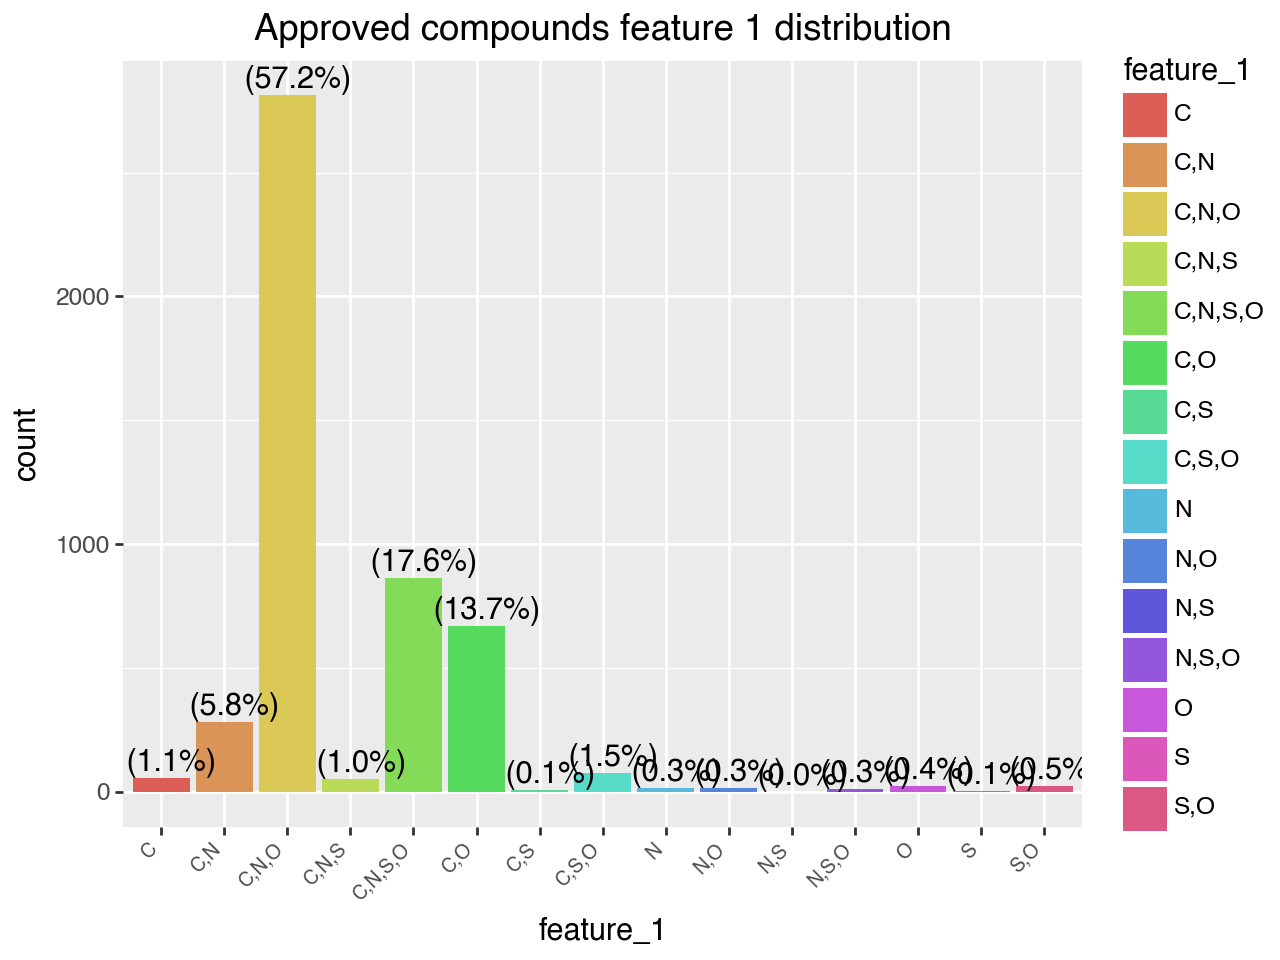

In [13]:
create_bar_plot(approved_compounds, "feature_1", "Approved compounds feature 1 distribution")

 Given the difference in categories and distributions of feature_1 in the spike positive compounds and in the general approved compounds, it is likely that feature_1 has a significant impact on activity agaisnt the covid-spike protein. We will confirm this with a Chi2 statistical test.


### Chi2 statistical test

In [14]:
#feature_1 values for the positive compounds:
pos_values = set(pos_compounds.feature_1.values)

#we get the counts from the spike positive compounds
d_pos = {}
for item in pos_compounds.feature_1.values:
    d_pos[item] = d_pos.get(item, 0) + 1
#here we add a 0 count for the rest:
d_pos['rest']=0


#we get the expected counts from the general approved compounds
d_a = {}
for item in approved_compounds.feature_1.values:
    if item in pos_values:
        d_a[item] = d_a.get(item, 0) + 1
##We count the rest for the approved compounds:
counter = 0
for value in approved_compounds.feature_1.values:
    if value not in pos_values:
        counter+=1
d_a['rest'] = counter


#We adjust the observed values to the number of approved compounds, as the opposite would end up with integers between 0 and 1.:
d_pos_norm = {k:round(v*len(approved_compounds)/len(pos_compounds),0) for k, v in d_pos.items()}

#we get the expected and observed values in order: 
## we first need to add "rest" to the pos_values set.
pos_values.add("rest")

expected_vals = [d_a[item] for item in pos_values]

observed_vals = [d_pos_norm[item] for item in pos_values]


# We perform the chi-squared test
chi2, p = stats.chisquare(observed_vals, f_exp=expected_vals)

print(f"Chi-squared test statistic: {chi2}, p-value: {p}")

Chi-squared test statistic: 707448.9739398577, p-value: 0.0


As we can see, the Chi-squared statistic is very large and the p value < 0.05, we can therefore confidently reject the hypothesis that the feature_1 values are the same in the overall approved compounds and the active compounds against the Covid-19 spike protein. 
As feature 1 values are significantly different in approved overall compounds and active compounds it is therefore highly likely that
feature 1 is significant for activity against the Covi-19 spike protein. 

## Feature 2 exploration

### Summary statistics

In [15]:
#get summary statistics in both datasets
pos_compounds.feature_2.describe()

count    50.000000
mean     14.705413
std       4.528186
min      10.146325
25%      11.600307
50%      13.110948
75%      16.387991
max      31.173711
Name: feature_2, dtype: float64

In [16]:
approved_compounds.feature_2.describe()

count    4913.000000
mean        0.207669
std        11.525513
min       -44.852145
25%        -8.750197
50%         0.234278
75%         9.464845
max        32.993710
Name: feature_2, dtype: float64

### Distributions

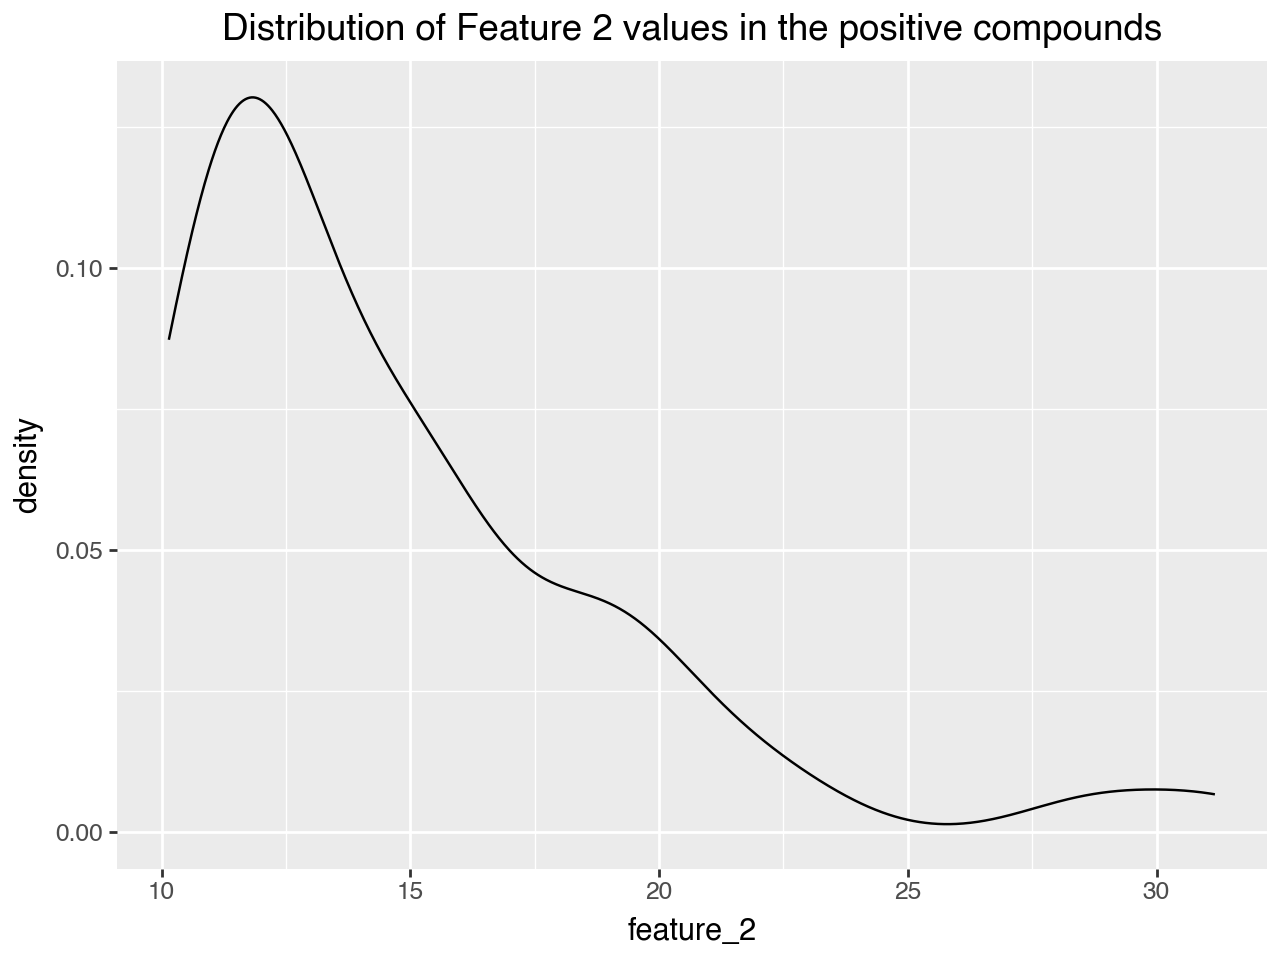

In [145]:
create_distribution_plot(pos_compounds, "feature_2", "Distribution of Feature 2 values in the positive compounds")

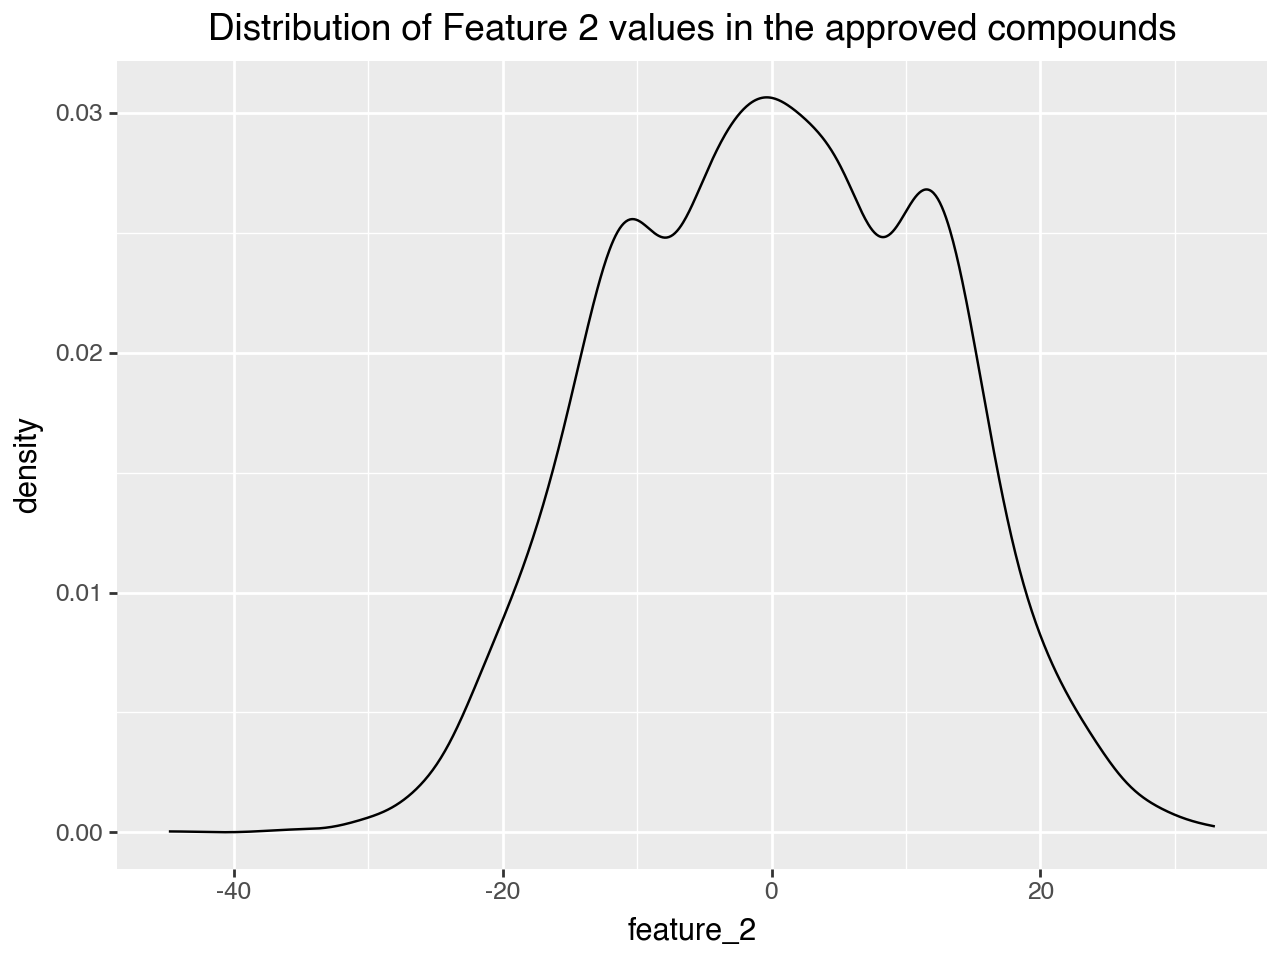

In [146]:
create_distribution_plot(approved_compounds, "feature_2", "Distribution of Feature 2 values in the approved compounds")

Feature 2 is looking also quite different between the approved and the positive compounds: the distributions not only have a different shape, but also their ranges are very different. We shall do a statistical test to confirm this.

### Statistical test 

In [19]:
#We first create a box plot to visualise the differences in feature 2 between the two datasets:
###create appropriate dataframe by concatenating both datasets:
approved_compounds['compound_type'] = "approved"
pos_compounds['compound_type'] = "positive"
total_compounds = pd.concat([approved_compounds, pos_compounds], axis=0)
total_compounds.shape

(4963, 5)

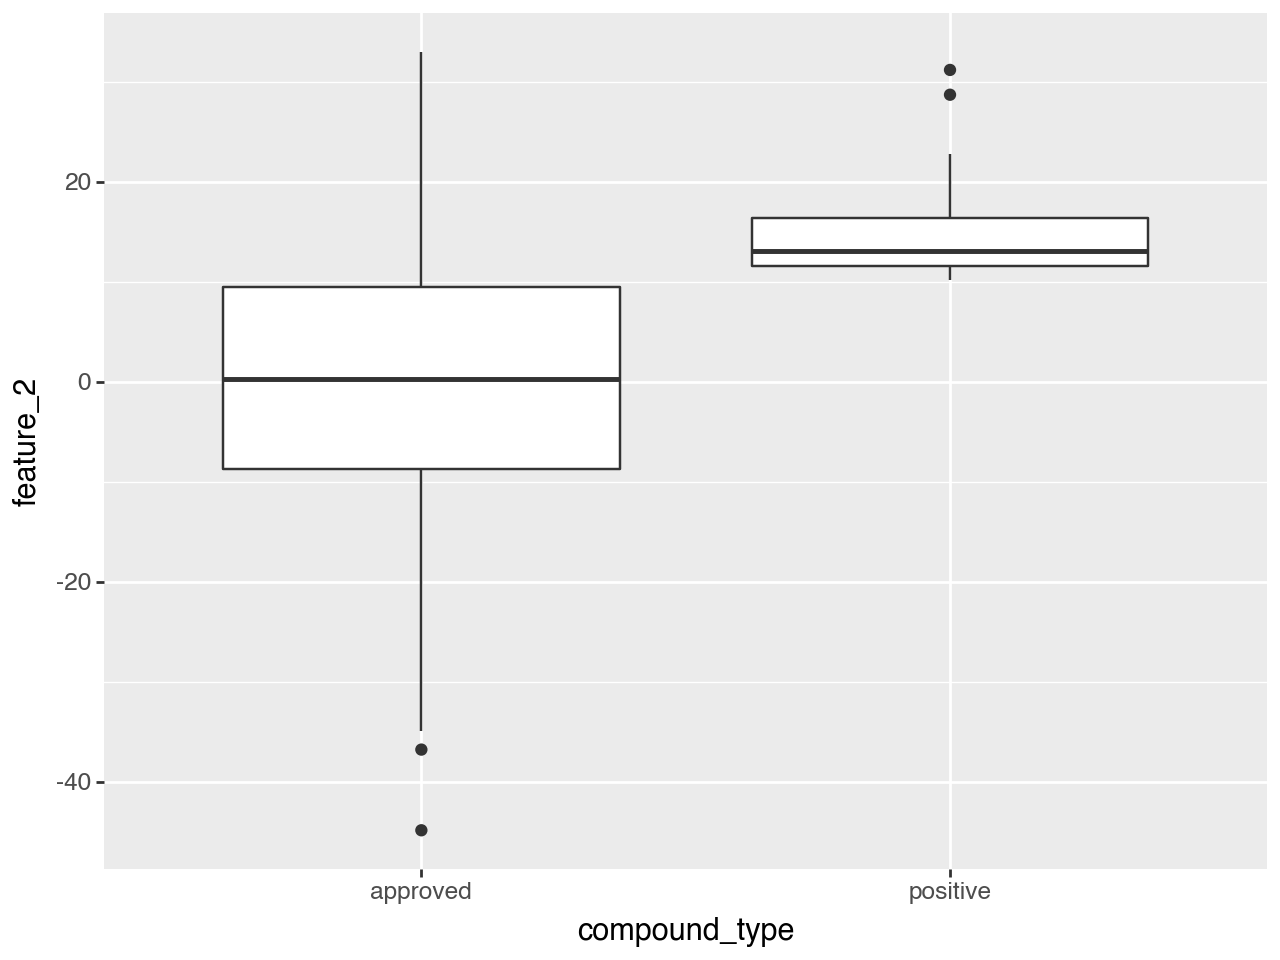

In [20]:
create_boxplot(total_compounds, "compound_type", "feature_2")

We can see that the feature_2 medians are quite different between the overall approved and the positive compounds. We therefore conduct statistical tests to see if there is a statistically significant difference. 

In [21]:
#First we do an Levene-test (as the distributions of feature_2 are not normal) to check for equality of variance :

levene_res = stats.levene(approved_compounds.feature_2.values, pos_compounds.feature_2.values)
print(f"The Levene test statistic is: {levene_res.statistic} and the p-value is {levene_res.pvalue}")
print("The Levene test statistic is high and the p-value is <0.05 so we can confidently reject \nthe null hypothesis of equality between the variances of the positive and approved compounds.")



The Levene test statistic is: 47.95630982818725 and the p-value is 4.913499649462287e-12
The Levene test statistic is high and the p-value is <0.05 so we can confidently reject 
the null hypothesis of equality between the variances of the positive and approved compounds.


In [22]:
#double check the difference in variance.

print(np.var(approved_compounds.feature_2.values), np.var(pos_compounds.feature_2.values))

132.8104146879776 20.09437572461335


In [160]:
#The ratio is bigger than 4 to 1 and we rejected the hypothesis of equality of variance so we therefore conduct a Welch's T-test of equality of the means
print(stats.ttest_ind(approved_compounds.feature_2.values, pos_compounds.feature_2.values, equal_var=False))


TtestResult(statistic=np.float64(-21.92787245790435), pvalue=np.float64(4.584404831770679e-29), df=np.float64(55.671911760108586))


The p-value of Welch's T-test is <0.05. We can therefore conclude that there is a significant difference between the mean of feature 2 in the Covid spike positive compounds versus the overall approved compounds. This strongly suggests that Feature 2 is significant in the activity of compounds against the Covid spike protein. 

## Feature 3 exploration

### Summary Statistics

In [90]:
approved_compounds.feature_3.describe()

count    4913.000000
mean        0.499595
std         0.287415
min         0.000132
25%         0.252323
50%         0.499155
75%         0.748173
max         0.999910
Name: feature_3, dtype: float64

In [91]:
pos_compounds.feature_3.describe()

count    50.000000
mean      0.445801
std       0.257356
min       0.004005
25%       0.236710
50%       0.453964
75%       0.652877
max       0.935747
Name: feature_3, dtype: float64

Feature 3 is not looking like it is very different we will anyway conduct a statistical test to confirm this.

In [94]:
approved_compounds.describe()

,feature_2,feature_3
count,4913.000000,4913.000000
mean,0.207669,0.499595
std,11.525513,0.287415
min,-44.852145,0.000132
25%,-8.750197,0.252323
50%,0.234278,0.499155
75%,9.464845,0.748173
max,32.993710,0.999910


In [95]:
pos_compounds.describe()

,feature_2,feature_3
count,50.000000,50.000000
mean,14.705413,0.445801
std,4.528186,0.257356
min,10.146325,0.004005
25%,11.600307,0.236710
50%,13.110948,0.453964
75%,16.387991,0.652877
max,31.173711,0.935747


### Distributions

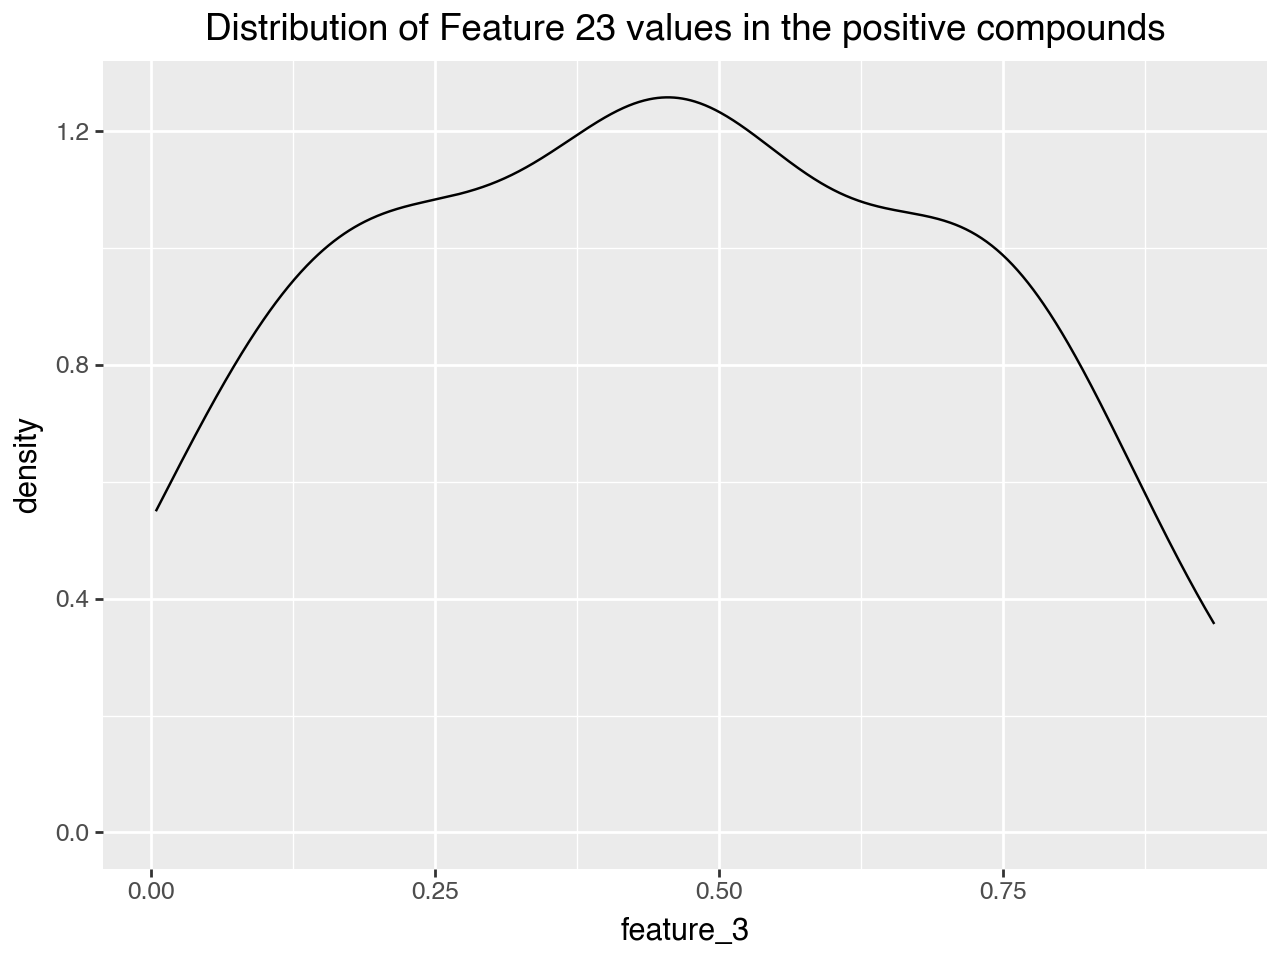

In [148]:
create_distribution_plot(pos_compounds, "feature_3", "Distribution of Feature 23 values in the positive compounds")

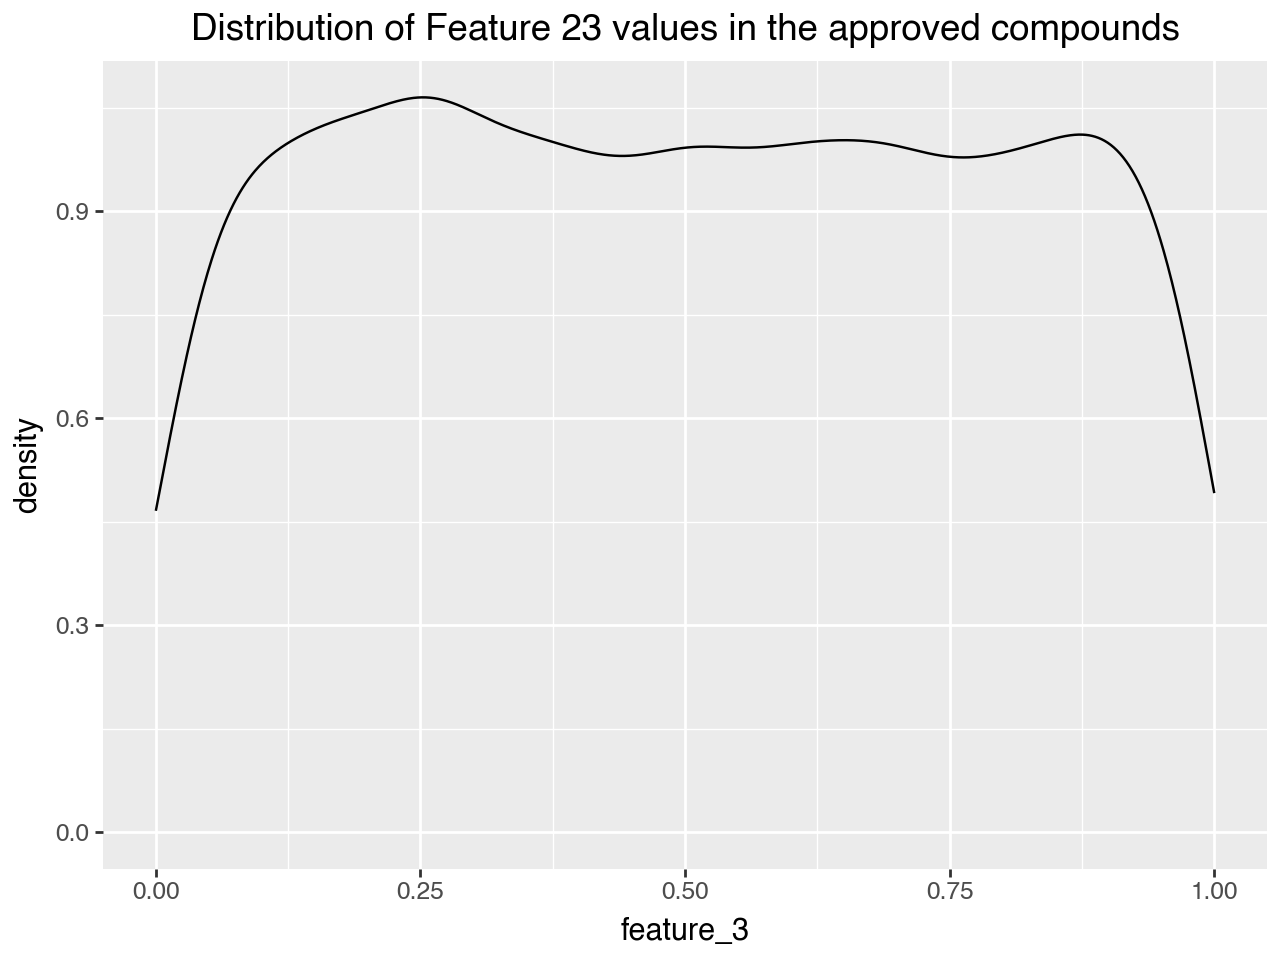

In [149]:
create_distribution_plot(approved_compounds, "feature_3", "Distribution of Feature 23 values in the approved compounds")

### Statistical test

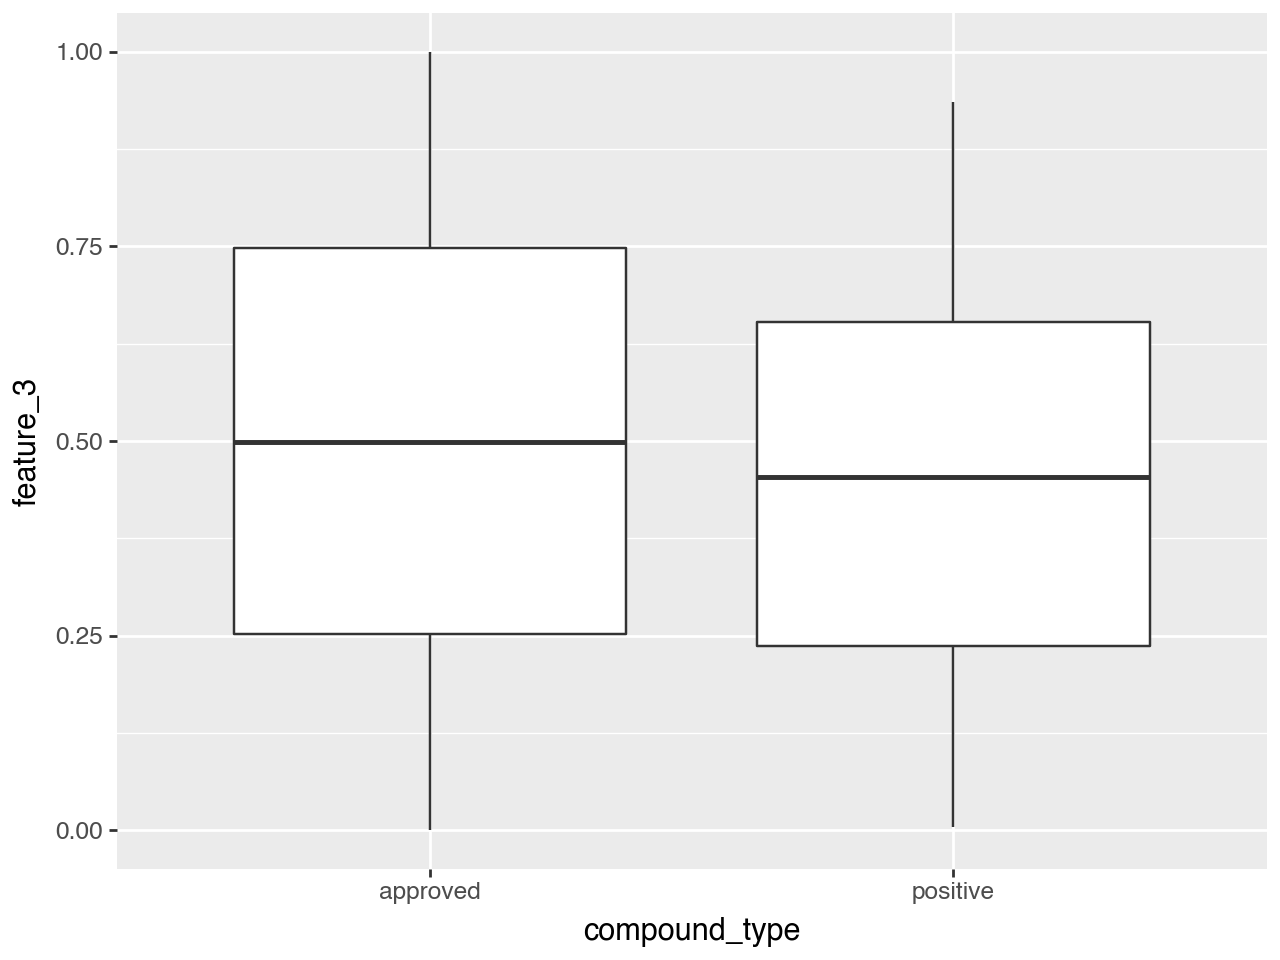

In [155]:
create_boxplot(total_compounds, "compound_type", "feature_3")

The box plot suggests that the medians of Feature 3 in the spike positive versus the general approved compounds are quite similar, which suggests that feature 3 might not be significant in finding an active compound against the Covid spike protein. To confirm this we will do several statistical tests. 

In [193]:
#First we do an Levene-test (as the distributions of feature_3 are not normal) to check for equality of variance :
levene_res = stats.levene(approved_compounds.feature_3.values, pos_compounds.feature_3.values)
print(f"The Levene test statistic is: {levene_res.statistic} and the p-value is {levene_res.pvalue}")
print("The Levene test statistic is low and the p-value is >0.05 so we cannot confidently reject \nthe null hypothesis of equality between the variances of the positive and approved compounds.")



The Levene test statistic is: 3.009809336566546 and the p-value is 0.08282413131658363
The Levene test statistic is low and the p-value is >0.05 so we cannot confidently reject 
the null hypothesis of equality between the variances of the positive and approved compounds.


So we continue with a Student's T-test to see if there is a difference in the means of feature 3 for the spike positive versus the general approved compounds.

In [23]:
#The ratio is bigger than 4 to 1 so we therefore conduct a Welch's T-test of equality of the means
print(stats.ttest_ind(approved_compounds.feature_3.values, pos_compounds.feature_3.values))

TtestResult(statistic=np.float64(1.3180561927968157), pvalue=np.float64(0.18754569271266547), df=np.float64(4961.0))


As the student's T test p-value is >0.05, we cannot reject the hypothesis that there is equality of the means of feature_3 between spike positive and general approved compounds. So it is unlikely that feature_3 is significant in the positivity of compounds against the Covid spike protein.

## Conclusion

It is highly likely that the categorical variable "feature_1" and the continuous variable "feature_2" are both significant in the activity of a compound against the Covid-19 spike protein. 